# Exploratory Data Analysis and Data Cleansing

# 1. Introduction

## 1.1 About the dataset 

The dataset contains Food Delivery data from a restaurant in Melbourne, Australia. The
restaurant has three branches around CBD area. All three branches share the same menu but
they have different management so they operate differently.

Each of the three provided datasets contain 500 records with the following attributes:

| Attribute | Description |
| --- | --- |
| order_id | A unique id for each order |
| date | The date the order was made in YYYY-MM-DD format|
| time | The time the order was made hh:mm:ss format |
| order_type | One of 3 types of order: Breakfast, Lunch or Dinner |
| branch_code | The branch code in which the order was made. One of 3 branches: BK, NS, TP |
| order_items | A list of tuples of the form: (Item ordered, Quantity ordered) |
| order_price | Total order price |
| customer_lat | Latitude of customer coming from nodes.csv |
| customer_lon | Longitude of customer coming from nodes.csv  |
| customerHasloyalty?  | Boolean variable representing if customer has loyalalty card |
| distance_to_customer_KM | Shortest distance between branch and customer node |
| delivery_fee | Delivery fee for an order |

## 1.2 Problem Description:

Data with missing values and outliers are separated here.

We will remove diffrerent types of anomalies in the dirty_data.csv, imput missing values in missing_df.csv and indentify outliers and remove it.

# 2. Methodology

This project involves multiple tasks related to Exploratory Data Analysis and Data Cleansing on three provided csv files.

The issues to address in these files are:
* Detecting and fixing errors. Errors can be syntactic, semantic or coverage.
* Detecting and removing outlier rows w.r.t. delivery_fee
* Imputing missing values

Solving all three of may require knowledge of the 'ground truth' to compare with and identify issues through records showing deviation. Hence, the first task would be to arrive at method to find this 'ground truth'. Studying the dirty_data and outlier_data datasets, it is found that it is not easy to identify records having issues. However, for the missing_data dataset, by removing records having null values, we are able to create a dataset that is a representation of the 'ground truth'. Further, all three datasets come from the same source, we can use this error-free dataset to find issues in the other two datasets.

Hence the order of completing the tasks is determined to be:

1. Impute missing values in the **missing_data** dataset using non-null records within the dataset
2. Using relevant records from the imputed dataset, identify and remove outliers in the **outlier_data** dataset
3. Using relevant records from the imputed dataset and other information from the dirty_data outliers, identify and correct errors in the **dirty_data** dataset.

## Importing libraries:

- **pandas** :  Used to handling dataframe and dataframe manipulation<br>
- **matplotlib** : For drawing plots of different format<br>
- **re** : Provides regular expression matching operations.<br>
- **numpy** :  Adds support for multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.<br>
- **Counter** : It is a subclass of Collection which is used to count hashable objects.<br>
- **networkx** : Used for the creation, manipulation of complex networks and also provides functions that can be used on the graphs.<br>
- **datetime** : To convert string object to a date object
- **sklearn.linear_model** : USed to develop a linear regression model.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import re
from collections import Counter
import networkx as nx
import numpy as np

%matplotlib inline
mpl.style.use('ggplot')

# To check convert a string object to a date object and to check if a date is a weekend
from datetime import datetime

# To create a model to understand relationship between delivery fee and other attributes
from sklearn.linear_model import LinearRegression

In [2]:
# Importing the provided datasets

#Dataset containing missing data
missing_df = pd.read_csv("data/missing_data.csv")
#dataset containing outliers
outlier_df = pd.read_csv("data/outlier_data.csv")

# 3. Imputing missing values 

This section deals with imputing missing values in the missing_data dataset. We begin by identifying the attributes containing missing values.

In [3]:
missing_df.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                100
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM     50
delivery_fee                50
dtype: int64

We observe that there are 100 records having missing branch_code values and 50 records each having missing distance_to_customer_KM and delivery_fee values.

We will first try to impute the missing values in the branch_code attribute. To do this, we take a look at the information provided in the other attributes in the dataset.

In [4]:
missing_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA08056,2018-06-17,13:34:38,Lunch,BK,"[('Steak', 10), ('Burger', 3), ('Fries', 1), (...",830.6,-37.809739,144.946342,0,9.146,17.700112
1,ORDA07709,2018-09-20,16:37:10,Dinner,BK,"[('Fish&Chips', 5), ('Pasta', 8)]",395.0,-37.814567,145.014384,0,4.417,10.764757
2,ORDY04563,2018-10-01,16:57:27,Dinner,NaN,"[('Shrimp', 9), ('Pasta', 9), ('Fish&Chips', 10)]",1083.5,-37.811819,144.975182,0,NaN,13.353060
3,ORDZ09301,2018-07-04,14:05:04,Lunch,NS,"[('Chicken', 10), ('Salad', 6), ('Fries', 1)]",435.2,-37.804138,145.002140,0,9.274,14.728902
4,ORDI07845,2018-10-22,17:48:10,Dinner,NS,"[('Shrimp', 2), ('Pasta', 9)]",355.5,-37.820019,144.961298,0,8.931,14.828467


### Impute missing branch_code

The order_id attribute seems to be a good place to start. From the above information in the dataset, we observe that the first four characters of the order_id attribute seems to repeat in some records. Hence, there can be a possibility of some order_ids being matched to particular branch_code.

So we will extract the first four characters of each of the order_ids and look for patterns that will help us identify the corresponding branch code.

In [5]:
# Extracting the first four characres of order_id in to order variable 
missing_df['order'] = missing_df['order_id'].apply(lambda x: x[:4])

In [6]:
# Plotting a cross tab of the order variable against the branch_code variable
pd.crosstab(missing_df["branch_code"],missing_df["order"])

order,ORDA,ORDB,ORDC,ORDI,ORDJ,ORDK,ORDX,ORDY,ORDZ
branch_code,,,,,,,,,
BK,45,0,0,0,0,47,42,0,0
NS,0,0,46,40,0,0,0,0,40
TP,0,54,0,0,44,0,0,42,0


From the crosstab, we observe that the first four characters of all order_ids belonging to a particular branch can only have one of three values. Further these values are disjointed among different branches. Hence, we can use this information to predict the values of missing branch_code.

- Orders starting with ORDA, ORDK, ORDX corresponds to BK
- Orders starting with ORDC, ORDI, ORDZ corresponds to NS
- Orders starting with ORDB, ORDJ, ORDY corresponds to TP

To do this, we first create a dictionary in the form of {order_id[:4], branch_code}

In [7]:
# Creating a list of order, branch_code combinations
branch_order_list = zip(list(missing_df[missing_df['branch_code'].notnull()]['order']),
                        list(missing_df[missing_df['branch_code'].notnull()]['branch_code'])
                        )
# Extracting distinct order, branch_code combinations and creating a dictionary
order_dict = dict(set(list(branch_order_list)))
print(order_dict)

{'ORDI': 'NS', 'ORDJ': 'TP', 'ORDZ': 'NS', 'ORDB': 'TP', 'ORDK': 'BK', 'ORDY': 'TP', 'ORDX': 'BK', 'ORDC': 'NS', 'ORDA': 'BK'}


Using this dictionary, we now predict the values of missing branch_code

In [8]:
missing_df['branch_code'] = missing_df['order'].apply(lambda x: order_dict[x])

In [9]:
missing_df.isnull().sum()

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM    50
delivery_fee               50
order                       0
dtype: int64

We can see that the missing values in branch_code has been successfully imputed.

## Imputing missing distance_to_customer data

Now we'll create a graph of network from edges.csv and nodes.csv to calculate the distance from restaurant branch to customer's location.

We will calculate distance using dijkstra's algorithm through networkx library.

In [10]:
edges_df = pd.read_csv('network_data/edges.csv')

## About edges_df:

**u, v** : represents nodes and each record indicates the presence of edge between u and v<br>
**distance(m)** : represents the distance between u and v nodes

In [11]:
edges_df.head()

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0


In [13]:
#list of all nodes in u column 
from_list = list(edges_df['u'])
#list of all nodes in v column 
to_list = list(edges_df['v'])
#distance between is stored in weight_list 
weight_list = list(edges_df['distance(m)'])

Let's build a list of tuples containing information about the edge

In [14]:
#List of tuple of structure(from_node, to_node, distance)
edges_list = list(zip(from_list,to_list,weight_list))

Now we will create graph and add edges to it.

In [15]:
mapGraph = nx.Graph()
mapGraph.add_weighted_edges_from(edges_list)

print("Number of Edges: ", mapGraph.number_of_edges())
print("Number of Edges: ", mapGraph.number_of_nodes())

Number of Edges:  25491
Number of Edges:  17117


We'll read the nodes.csv file to get information about how latitude and longitude is mapped to node

In [16]:
nodes_df = pd.read_csv('network_data/nodes.csv')
nodes_df.head()

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


## About nodes_df

**node** : name of the node<br>
**lat** : latitude for the node<br>
**lon** : longitude for the node<br>

We will merge nodes_df and missing_df to get the nodes corresponding to latitude and longitude.

In [17]:
missing_df = pd.merge(missing_df, nodes_df, how='inner',left_on = ['customer_lat', 'customer_lon'], right_on= ['lat', 'lon'])

#Drop unnecessary repeating nodes
missing_df.drop(['lat', 'lon'], axis=1, inplace=True)

print(len(missing_df))

500


## Read branches.csv

In [18]:
branches_df = pd.read_csv('network_data/branches.csv')
branches_df.head()

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


### About branches_df:
**branch_code** : branch code of the restaurant<br>
**branch_name** : branch name of the restaurant<br>
**branch_lat** : latitude of restaurant branch<br>
**branch_lon** : longitude of restaurant branch<br>

To find node corresponsing to each branch, we will merge `branches_df` and `nodes_df`

In [19]:
branches_df = pd.merge(branches_df, nodes_df, left_on=['branch_lat', 'branch_lon'], right_on = ['lat','lon'])
branches_df.head()

,branch_code,branch_name,branch_lat,branch_lon,node,lat,lon
0,NS,Nickolson,-37.773803,144.983647,2455254505,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716,1390575046,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450,1889485053,-37.815834,145.046450


In [20]:
#rename column to from_node
branches_df.rename(columns={'node': 'from_node'}, inplace=True)

Now we will merge missing_df and branches_df to get corresponding node of branch as a column value which can help easy dataframe manipulation.

In [21]:
missing_df = pd.merge(missing_df, branches_df[['branch_code', 'from_node']], on="branch_code")
missing_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,order,node,from_node
0,ORDA08056,2018-06-17,13:34:38,Lunch,BK,"[('Steak', 10), ('Burger', 3), ('Fries', 1), (...",830.6,-37.809739,144.946342,0,9.146,17.700112,ORDA,4638961335,1889485053
1,ORDA07709,2018-09-20,16:37:10,Dinner,BK,"[('Fish&Chips', 5), ('Pasta', 8)]",395.0,-37.814567,145.014384,0,4.417,10.764757,ORDA,2296606723,1889485053
2,ORDX04562,2018-03-29,10:52:23,Breakfast,BK,"[('Cereal', 6), ('Eggs', 9), ('Coffee', 10)]",399.0,-37.811557,144.993585,0,4.836,9.859001,ORDX,412776174,1889485053
3,ORDX04292,2018-07-11,14:15:12,Lunch,BK,"[('Steak', 2), ('Chicken', 4), ('Salad', 10)]",390.0,-37.814464,145.007796,0,3.741,9.355473,ORDX,1463620411,1889485053
4,ORDK00534,2018-03-23,10:42:15,Breakfast,BK,"[('Cereal', 6), ('Coffee', 1), ('Eggs', 1)]",155.5,-37.814883,144.927115,0,NaN,16.663016,ORDK,206204608,1889485053


Function to calculate dijkstra distance between two nodes.

In [22]:
def f(x):
    return (nx.dijkstra_path_length(mapGraph, x[0],x[1]))/1000

Imputing null values of distance with distance found using above function(dijkstra distance).

In [23]:
missing_df.loc[missing_df['distance_to_customer_KM'].isnull(),\
               'distance_to_customer_KM'] = missing_df[missing_df['distance_to_customer_KM'].isnull()][['from_node','node']].apply(\
                    lambda x: f(x), axis=1)

lets check if all the nulls are imputed correctly and no nulls are left in distance_to_customer_KM column.

In [24]:
missing_df.isna().sum()

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM     0
delivery_fee               50
order                       0
node                        0
from_node                   0
dtype: int64

### Imputing missing delivery_fee

We will now impute the missing values present in the delivery_fee attribute.

We suspect that delivery_fee is calculated is a different method for each branch based on:

* weekend or weekday
* time of the day
* distance between branch and customer

Further if a customer has loyalty, they get a 50% discount on delivery fee.

Using this information we will build a linear regression model to impute missing values of delivery_fee. We build this model using the 450 records in the dataframe having non-null delivery_fee values as the training dataset. For this, we create two datasets separating the null records from the others. 

In [25]:
# Extracting records for which delivery_fee is to be predicted
predict_df = missing_df.loc[missing_df['delivery_fee'].isnull()]

# Extracting non-null records to use as training data
not_null_df = missing_df.dropna()

We will now transform the datasets to create new variables to be used for predicting. The transformations done are:
* is_weekend: Extracting day of week from the date variable to identify if a date is weekend or not (weekend:1, else:0)
* time_of_day: Extracting hour from the time variable to identify time of day ([8-11]:0 , [12-15]:1, [16-20]:2)
* norm_deliv_fee: Normalising delivery fee for customers having loyalty (norm_deliv_fee = delivery_fee*2)

We create the below function to carry out these transformations.

In [26]:
def lr_transform(data_frame):
    
    # Creating a variable to record if the date falls on a weekend or not
    data_frame = data_frame.assign(is_weekend=[1 if datetime.strptime(x, '%Y-%m-%d').weekday() >= 5 \
                                               else 0 for x in data_frame['date']])
    
    # Creating variables to collect hour of order and time of day of order
    data_frame = data_frame.assign(time_of_day = 99)
    data_frame = data_frame.assign(order_hour = 0)
    
    # Calculating time of day for each record
    data_frame['order_hour'] = data_frame['time'].apply(lambda x: int(re.findall('([\d]+)',x)[0]))
    data_frame['time_of_day'] = data_frame['order_hour'].apply(lambda x: min((x - 8)//4,2))
    
    # Creating variables to collect normalised delivery fee
    data_frame = data_frame.assign(norm_deliv_fee = 0)
    
    # Creating a function to return normalised delivery fee
    def deliv_norm (fee, loyal):
        return fee*(loyal+1)
    
    # Calculating normalised delivery fee for each record
    data_frame['norm_deliv_fee'] = data_frame.apply(lambda x: deliv_norm(x['delivery_fee'], x['customerHasloyalty?']), axis=1)
    
    return data_frame

We now create training and testing datasets by transforming the not_null and predict dataframes created before. 

In [27]:
train_df = lr_transform(not_null_df)
test_df = lr_transform(predict_df)

As the delivery fee is calculated using a different method for each branch, we will create separate regression models for each branch.

In [28]:
# Creating filters for each branch
bk_filter = train_df['branch_code'] == 'BK'
tp_filter = train_df['branch_code'] == 'TP'
ns_filter = train_df['branch_code'] == 'NS'

# Selecting predictor variables
attributes = ['is_weekend', 'time_of_day','distance_to_customer_KM']

# Creating a matrix of predictor variables for each branch
bk_attributes = train_df[bk_filter][attributes].values.tolist()
tp_attributes = train_df[tp_filter][attributes].values.tolist()
ns_attributes = train_df[ns_filter][attributes].values.tolist()

# Creating a matrix of target variable for each branch
bk_target = train_df[bk_filter]['norm_deliv_fee'].values.tolist()
tp_target = train_df[tp_filter]['norm_deliv_fee'].values.tolist()
ns_target = train_df[ns_filter]['norm_deliv_fee'].values.tolist()

# Initialising models
bk_model = LinearRegression()
tp_model = LinearRegression()
ns_model = LinearRegression()

# Fitting linear regression models for each branch
bk_model.fit(bk_attributes, bk_target)
tp_model.fit(tp_attributes, tp_target)
ns_model.fit(ns_attributes, ns_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

To check the validity of the models, we calculate their R^2 values  

In [29]:
print(bk_model.score(bk_attributes, bk_target))
print(tp_model.score(tp_attributes, tp_target))
print(ns_model.score(ns_attributes, ns_target))

0.9797359182651348
0.9498079279438684
0.9602466998222543


As all three models have R^2 values in mid-higher 90's, we accept the validity of the models.

We now create a function to return the predicted value of delivry_fee after applying the 50% discount for customers having loyalty 

In [30]:
def prediction (branch, is_weekend, time_of_day, distance, is_loyal):
    if branch == 'BK':
        return bk_model.predict([[is_weekend, time_of_day, distance]])/(is_loyal + 1)
    elif branch == 'TP':
        return tp_model.predict([[is_weekend, time_of_day, distance]])/(is_loyal + 1)
    elif branch == 'NS':
        return ns_model.predict([[is_weekend, time_of_day, distance]])/(is_loyal + 1)

Using this function, we predict delivery_fee for records having missing delivery_fee values.

In [31]:
# Calculating predicted delivery fee
test_df['delivery_fee'] = test_df.apply(
    lambda x: prediction(x['branch_code'],x['is_weekend'],x['time_of_day'],\
                         x['distance_to_customer_KM'],x['customerHasloyalty?'])[0], axis=1)

We then append this dataframe containing predicted delivery_fee to the dataframe having non-null delivery_fee to create the required output csv file

In [32]:
# Appending predicted delivery_fee records to non-null delivery_fee records 
missing_data_solution_df = train_df.append(test_df, sort=False)

# Dropping unwanted columns
missing_data_solution_df.drop(['order','node','from_node','is_weekend','time_of_day','order_hour','norm_deliv_fee'], inplace=True, axis=1)

# Writing the dataframe to a csv file
missing_data_solution_df.to_csv('missing_data_solution.csv', index=False)

# 4. Detecting and removing outlier records

To find the outliers in the dataset, the approach followed is to use the linear regression model built for imputing missing data to predict delivery fee values for each record in the outlier_data dataset. Once the delivery_fee values are predicted, we calculate residuals as the difference in values between the predicted delivery fee and the actual delivery fee. We then identify outliers for each branch as those records for which the residual is significantly higher in magnitude than the average value of residual for all records for a branch and then remove them. This is done by creating boxplots of the distribution of residuals for each branch and identifying all records lying beyond Q1 - 1.5 IQR and Q3 + 1.5 IQR (Q1 - 1st quartile, Q3 - 3rd quartile, IQR - inter quartile range).

We transform the outlier_df to create the required predictor variables and then predict the value of delivery fee using the prediction function created earlier.

In [33]:
# Transforming the outlier_df to create the required predictor variables
test_df = lr_transform(outlier_df)

# Initialising variable to store predicted delivery fee
test_df = test_df.assign(pred_delivery_fee = 0)

# Calculating predicted delivery fee
test_df['pred_delivery_fee'] = test_df.apply(
                                    lambda x: prediction(x['branch_code'],x['is_weekend'],x['time_of_day'],\
                                                         x['distance_to_customer_KM'], x['customerHasloyalty?'])[0],axis=1)

Calculating residuals as the difference between the predicted delivery fee and the delivery fee present in the dataset for each record.

In [34]:
# Creating a function to calculate the residuals
def calc_difference (x, y):
        return x - y

# Calculating the residuals
test_df['residuals'] = test_df.apply(lambda x: calc_difference(x['pred_delivery_fee'],x['delivery_fee']), axis=1)

We the plot the values of residuals in boxplots grouped by branch code to understand the variance of residuals

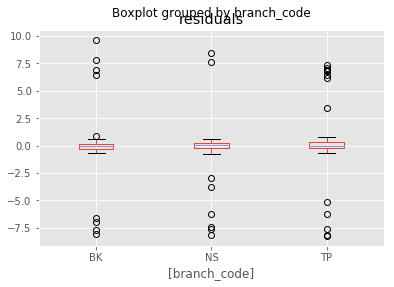

In [35]:
boxplot = test_df.boxplot(column=['residuals'], by=['branch_code'])

From the boxplots, we can see the presence of outliers. Here, the outliers are those points for which the value of the residual is significantly higher (value in dataset is significantly lower than value predicted by model) or significantly lower (value in dataset is significantly higher than value predicted by model) than the average residual. We will now programatically identify these records and then remove them.

To do this we calculate upper and lower bounds as Q3 + 1.5 IQR and Q1 + 1.5 IQR (Q1 - 1st quartile, Q3 - 3rd quartile, IQR - inter quartile range) and remove those records for which the residuals lie outside the upper and lower bounds.

In [36]:
# Creating filters for each branch
bk_filter_test = test_df['branch_code'] == 'BK'
tp_filter_test = test_df['branch_code'] == 'TP'
ns_filter_test = test_df['branch_code'] == 'NS'

In [37]:
# Calculating Q1 for each branch
bk_q1 = test_df[bk_filter_test]['residuals'].quantile(0.25)
tp_q1 = test_df[tp_filter_test]['residuals'].quantile(0.25)
ns_q1 = test_df[ns_filter_test]['residuals'].quantile(0.25)

# Calculating Q3 for each branch
bk_q3 = test_df[bk_filter_test]['residuals'].quantile(0.75)
tp_q3 = test_df[tp_filter_test]['residuals'].quantile(0.75)
ns_q3 = test_df[ns_filter_test]['residuals'].quantile(0.75)

# Calculating IQR for each branch
bk_iqr = bk_q3 - bk_q1
tp_iqr = tp_q3 - tp_q1
ns_iqr = ns_q3 - ns_q1

# Creating dictionaries to store lower (Q1 -1.5IQR) and upper (Q3 +1.5IQR) bounds of residuals for each branch
lower_dict = {"BK":bk_q1 - 1.5*bk_iqr,
        "TP":tp_q1 - 1.5*tp_iqr,
        "NS":ns_q1 - 1.5*ns_iqr
        }

upper_dict = {"BK":bk_q3 + 1.5*bk_iqr,
        "TP":tp_q3 + 1.5*tp_iqr,
        "NS":ns_q3 + 1.5*ns_iqr
        }

In [38]:
# Creating function to check if the residual for a record lies within created bounds
def outlier_filter(branch, residual):
    return (lower_dict[branch] <= residual) & (residual <= upper_dict[branch])    

# Removing records where residuals lie beyond bounds
outlier_data_solution_df = test_df[test_df[['branch_code','residuals']].apply(lambda x: outlier_filter(*x), axis=1)]

Plotting the boxplots again, we see that outliers from the previous boxplot has been removed

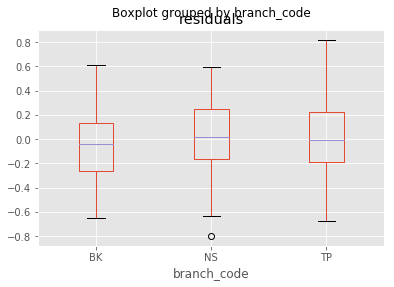

In [39]:
boxplot = outlier_data_solution_df.boxplot(column = 'residuals', by = 'branch_code')

We then drop the unecessary attributes and export the dataframe to a csv file.

In [40]:
outlier_data_solution_df = outlier_data_solution_df.drop(
    ['is_weekend','time_of_day','order_hour','norm_deliv_fee','pred_delivery_fee','residuals'],axis=1
)
outlier_data_solution_df.to_csv('outlier_data_solution.csv', index=False)

# 5. Working on dirty_data.csv file

**Note:** e1, e2, e3.... are list containing index of rows having errors. They are commented out as it won't be useful in the exploration. It was used to see we are making any errors or not.

In [150]:
#Set max column width
pd.options.display.max_colwidth = 80

In [151]:
#Reading dirty data
dirty_df = pd.read_csv("data/dirty_data.csv")
dirty_df.head(5)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDX05220,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 8), ('Shrimp', 3), ('Fish&Chips', 2), ('Pasta', 7)]",752.5,-37.807758,144.943627,0,8.090,16.146092
1,ORDY02858,2018-12-26,19:49:51,Dinner,TP,"[('Pasta', 9), ('Salmon', 1), ('Fish&Chips', 2)]",358.5,-37.801732,144.957615,0,9.510,13.251254
2,ORDJ07185,2018-11-09,18:18:35,Dinner,TP,"[('Fish&Chips', 1), ('Salmon', 4), ('Shrimp', 9)]",685.0,-37.814718,144.950696,0,9.005,13.174748
3,ORDB06291,2018-01-03,08:00:00,Breakfast,TP,"[('Cereal', 3), ('Coffee', 7), ('Pancake', 8)]",309.5,-37.812759,144.941368,1,10.136,6.085497
4,ORDI09940,2018-07-18,14:35:29,Lunch,NS,"[('Burger', 3), ('Fries', 7)]",177.0,-37.800347,144.978114,0,6.858,12.301354


In [152]:
print(dirty_df.shape)

(500, 12)


Lets find information about the data

In [153]:
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
order_id                   500 non-null object
date                       500 non-null object
time                       500 non-null object
order_type                 500 non-null object
branch_code                500 non-null object
order_items                500 non-null object
order_price                500 non-null float64
customer_lat               500 non-null float64
customer_lon               500 non-null float64
customerHasloyalty?        500 non-null int64
distance_to_customer_KM    500 non-null float64
delivery_fee               500 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


We can get information about numerical column using describe() function

In [154]:
dirty_df.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,494.581300,-30.754085,143.506193,0.144000,8.622980,13.640700
std,281.438243,25.335936,16.299874,0.351441,1.748958,2.662861
min,53.200000,-37.833683,-37.826316,0.000000,3.562000,4.094509
25%,284.687500,-37.817937,144.952804,0.000000,7.721250,12.387891
50%,445.800000,-37.811753,144.965168,0.000000,8.807000,14.032986
75%,670.200000,-37.803984,144.982821,0.000000,9.753500,15.307046
max,1458.500000,145.003905,145.015819,1.000000,13.515000,19.621169


Max of customer_lat is too high.
Min of customer_lon is too low.

Also, std is not too high that means there will be considerable record with high values.

Lets check these records

As the records are from a Melbourne restaurant so latitude of the location from where the order is placed, should be within Melbourne's vicinity. So, the customer_lat should be within (-37,-38).

Let's check how many records falls in this range.

## 5.1 Fix customer_lat and customer_lon

In [155]:
#find number of rows within (-38,-37)
dirty_df[(dirty_df['customer_lat']<-37) & (dirty_df['customer_lat']>-38)].shape

(459, 12)

So, out of 500, 41 (500-459) records seems misleading, we need to check those records.

In [47]:
dirty_df.loc[dirty_df['customer_lat']>-37,'customer_lat'].describe()

count     41.000000
mean      48.264182
std       32.189473
min       37.793692
25%       37.804632
50%       37.811780
75%       37.818792
max      145.003905
Name: customer_lat, dtype: float64

**75%** values are around 37 which implies that they are recorded wrongly and those values should be changed to negative.

In [160]:
#finding rows with error in sign.
dirty_rows = (dirty_df['customer_lat']>37) & (dirty_df['customer_lat']<38)

In [165]:
# e1 = list(dirty_df[dirty_rows].index)

In [162]:
dirty_df[dirty_rows].shape

(37, 12)

We will change the sign of these rows using lambda function.

In [166]:
dirty_df.loc[dirty_rows,'customer_lat'] = dirty_df.loc[dirty_rows,'customer_lat'].apply(lambda x: -x)

Out of 41 errors, we have solved 37 rows having error in sign.<br>
Still there are 4 discrepancies in the data.

In [170]:
# e2 = dirty_df.loc[dirty_df['customer_lat']>38,'customer_lat'].index

In [51]:
#select rows with more than 38 values for customer_lat
dirty_df.loc[dirty_df['customer_lat']>38,'customer_lat']

53     145.003905
95     144.982362
231    144.931762
445    144.935406
Name: customer_lat, dtype: float64

Before we correct this, let's look at longitude errors

We can see from the distribution that most of the value (**75%**) are around 144-146. 
Lets check how many follows this range.

In [52]:
#find number of rows having customer_lon falling outside (144-146)
dirty_df[(dirty_df['customer_lon']>144) & (dirty_df['customer_lon']<146)].shape

(496, 12)

So there are 4 (total 500 - 496) rows which needs to be investigated.

In [53]:
#select rows with customer_lon less than 144
dirty_rows = dirty_df['customer_lon']<144

In [54]:
dirty_df[dirty_rows]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
53,ORDI01737,2018-04-25,11:43:05,Breakfast,NS,"[('Cereal', 3), ('Eggs', 6), ('Coffee', 3), ('Pancake', 8)]",411.5,145.003905,-37.826316,0,10.911,16.004994
95,ORDB02133,2018-11-25,18:49:00,Dinner,TP,"[('Fish&Chips', 9), ('Salmon', 9), ('Pasta', 1)]",711.5,144.982362,-37.820867,0,9.014,15.541348
231,ORDI01819,2018-12-14,19:29:34,Dinner,NS,"[('Salmon', 5), ('Fish&Chips', 10), ('Pasta', 9)]",802.5,144.931762,-37.816983,0,9.432,15.356441
445,ORDZ05961,2018-09-03,16:06:45,Dinner,NS,"[('Fish&Chips', 5), ('Pasta', 7), ('Shrimp', 7), ('Salmon', 9)]",1114.5,144.935406,-37.814916,0,10.208,16.206351


In fact, these are the same records in which we still have discrepancies in customer_lat column.

From the geography of Melbourne, it seems that customer_lat and customer_lon are interchanged. We need to fix these lines.

We will interchange values for these rows.

In [55]:
#Interchange values for customer_lat and customer_lon for these rows
dirty_df.loc[dirty_rows,['customer_lat','customer_lon']] = dirty_df.loc[dirty_rows,['customer_lon','customer_lat']].values

## 5.2 Fix order_type errors

In [57]:
dirty_df.describe(include=['O'])

,order_id,date,time,order_type,branch_code,order_items
count,500,500,500,500,500,500
unique,500,299,72,3,6,497
top,ORDJ06288,2018-02-27,15:36:20,Lunch,NS,"[('Shrimp', 1), ('Salmon', 6)]"
freq,1,8,18,170,165,2


[('Shrimp', 1), ('Salmon', 6)] appears twice. While two orders can have same order_items, it's better to check those two orders if they are repeated or not.

In [58]:
dirty_df[dirty_df['order_items']=='[(\'Shrimp\', 1), (\'Salmon\', 6)]']

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
13,ORDX01196,2018-12-16,19:29:34,Dinner,BK,"[('Shrimp', 1), ('Salmon', 6)]",300.0,-37.824406,144.944700,0,11.156,19.405397
236,ORDB02964,2018-09-16,16:27:02,Dinner,TP,"[('Shrimp', 1), ('Salmon', 6)]",300.0,-37.816526,144.955695,0,8.370,14.256927


Both orders look alright.

Checking if time follows the actual (8am-8pm) time format.

In [171]:
timerows =  dirty_df['time'].apply(
    lambda x: True if re.match(r'(?:0[89]|1\d):(?:[012345]\d):(?:[012345]\d)|20:00:00',x) else False
)
timerows.value_counts()

True    500
Name: time, dtype: int64

Breakfast orders are made from 8:00:00 am to 12:00:00 so we will check if order made during these time has order_type value as 'Breakfast'

```python
re.match(r'(0[89]|1[01]):([012345]\d):([012345]\d)|12:00:00',x)
```
This will match either '08', '09', '10', '11' followed by ':' followed by any digit from [0-5] and a digit from [0-9] then a ':' after which any digit from [0-5] and any digit or 12:00:00 

In [172]:
#Select orders placed during 8:00:00 am to 12:00:00 pm
breakfast_rows =  dirty_df['time'].apply(
    lambda x: True if re.match(r'(0[89]|1[01]):([012345]\d):([012345]\d)|12:00:00',x) else False
)
breakfast_rows.value_counts()

False    329
True     171
Name: time, dtype: int64

Lunch orders are made from 12:00:01pm to 4:00:00pm so we will check if order made during these time has order_type value as 'Lunch'
```python
re.match(r'(1[345]:[012345]\d:[012345]\d)|(12:0(0:0[1-9]|0:[1-5]\d|[1-9]:[0-5]\d)|12:[1-5]\d:[0-5]\d)|16:00:00',x)
```
This regular expression will match 1 followed by '3', '4' or '5' then ':' followed by any digit from [0-5] then any digit.<br>
*This covers time from 13:00:00 to 15:59:59*

**OR** '12:0' followed by '0:0' with any digit from [1-9] or '0:' followed by any digit from [1-5] then any digit or [1-9] followed by ':' followed by a digit from [0-5] then any digit.<br>
*This covers time from 12:00:01 to 12:09:59*

**OR** '12:' followed by a digit from [1-5] followed by any digit followed by ':' then a digit from [0-5] followed by a digit
*This covers time from 12:10:00 to 12:59:59*<br>

**OR** 16:00:00

In [173]:
#Select orders placed during 12:00:01pm to 4:00:00pm
lunch_rows =  dirty_df['time'].apply(
    lambda x: True if re.match(r'(1[345]:[012345]\d:[012345]\d)|(12:0(0:0[1-9]|0:[1-5]\d|[1-9]:[0-5]\d)|12:[1-5]\d:[0-5]\d)|16:00:00',x) else False
)
lunch_rows.value_counts()

False    333
True     167
Name: time, dtype: int64

Dinner orders are made from 16:00:01 to 20:00:00 so we will check if order made during these time has order_type value as 'Dinner'
```python
re.match(r'(1[789]:[012345]\d:[012345]\d)|(16:0(0:0[1-9]|0:[1-5][0-9]|[1-9]:[0-5]\d)|16:[1-5]\d:[0-5]\d)|20:00:00',x)
```
This regular expression will match 1 followed by '7', '8' or '9' then ':' followed by any digit from [0-5] then any digit.<br>
*This covers time from 17:00:00 to 19:59:59*

**OR** '12:0' followed by '0:0' with any digit from [1-9] or '0:' followed by any digit from [1-5] then any digit or [1-9] followed by ':' followed by a digit from [0-5] then any digit.<br>
*This covers time from 16:00:01 to 16:09:59*

**OR** '16:' followed by a digit from [1-5] followed by any digit followed by ':' then a digit from [0-5] followed by a digit
*This covers time from 16:10:00 to 16:59:59*<br>

**OR** 20:00:00

In [174]:
#Select orders placed during 4:00:01pm to 8:00:00pm
dinner_rows =  dirty_df['time'].apply(
    lambda x: True if re.match(r'(1[789]:[012345]\d:[012345]\d)|(16:0(0:0[1-9]|0:[1-5][0-9]|[1-9]:[0-5]\d)|16:[1-5]\d:[0-5]\d)|20:00:00',x) else False
)
dinner_rows.value_counts()

False    338
True     162
Name: time, dtype: int64

If we filter the dataframe with these rows we see that there are errors in order_type values

In [175]:
#find count of order_type of orders made in breakfast time
dirty_df.loc[breakfast_rows,'order_type'].value_counts()

Breakfast    153
Lunch          9
Dinner         9
Name: order_type, dtype: int64

We see that 9 breakfast rows have Dinner as its order_type. Also, 9 breakfast rows have Lunch as its order_type. This is incorrect so we need to fix these errors so we will assign order_type value as **'Breakfast'** for these rows having incorrect order_type.

In [184]:
# e3 = dirty_df[breakfast_rows][dirty_df[breakfast_rows]['order_type'] != 'Breakfast'].index
# e4 = dirty_df[lunch_rows][dirty_df[lunch_rows]['order_type'] != 'Lunch'].index
# e5 = dirty_df[dinner_rows][dirty_df[dinner_rows]['order_type'] != 'Dinner'].index

In [185]:
#Assign order_type values for rows having error to 'Breakfast'
dirty_df.loc[breakfast_rows & (dirty_df[breakfast_rows]['order_type'] != 'Breakfast'),'order_type'] = 'Breakfast'

Let's check these errors for orders made in Lunch time

In [186]:
#find count of order_type of orders made in lunch time
dirty_df.loc[lunch_rows,'order_type'].value_counts()

Lunch        157
Breakfast      5
Dinner         5
Name: order_type, dtype: int64

We see that 5 lunch rows have Dinner as its order_type. Also, 5 lunch rows have Breakfast as its order_type. This is incorrect so we need to fix these errors so we will assign order_type value as **'Lunch'** for these rows having incorrect order_type.

In [187]:
#Assign order_type values for rows having error to 'Lunch'
dirty_df.loc[lunch_rows & (dirty_df[lunch_rows]['order_type'] != 'Lunch'),'order_type'] = 'Lunch'

Checking this type of errors in the orders made in Dinner time

In [188]:
#find count of order_type of orders made in dinner time
dirty_df.loc[dinner_rows,'order_type'].value_counts()

Dinner       153
Breakfast      5
Lunch          4
Name: order_type, dtype: int64

We see that 5 dinner rows have Breakfast as its order_type. Also, 5 dinner rows have Lunch as its order_type. This is incorrect so we need to fix these errors so we will assign order_type value as **'Dinner'** for these rows having incorrect order_type.

In [189]:
#Assign order_type values for rows having error to 'Dinner'
dirty_df.loc[dinner_rows & (dirty_df[dinner_rows]['order_type'] != 'Dinner'),'order_type'] = 'Dinner'

We can see anomalies in the order_type as there is mismatch in the count of rows having stipulated time period for breakfast, lunch, dinner and column with order_type.

## 5.3 Fix order_date

We begin by checking for records having date not in the YYYY-MM-DD format.

In [194]:
dirty_rows = dirty_df['date'].apply(lambda x: True if(len(re.findall('(\d{4}-\d{2}-\d{2})',x)))==0 else False)

In [195]:
dirty_df[dirty_rows]['date']

14     09-01-2018
176    05-11-2018
239    01-08-2018
243    09-07-2018
271    12-08-2018
288    08-12-2018
306    01-03-2018
309    02-08-2018
312    10-07-2018
322    06-07-2018
387    07-11-2018
392    03-01-2018
468    04-08-2018
Name: date, dtype: object

These records appear to be in the DD-MM-YYYY format. The following code block is to fix these errors.

In [71]:
for i in range(len(dirty_df)):
    if(len(re.findall('(\d{4}-\d{2}-\d{2})',dirty_df['date'][i])))==0:
        date_list = (re.findall('([\d]+)',dirty_df['date'][i]))
        dirty_df.iloc[i,1] = date_list[2] + '-' + date_list[1] + '-' + date_list[0]

The next task is to check for the presence of semantic errors in the date column. To do this, we check for cases where the month >12 or day >31. In all records, we find that the value of day <31 - hence we assume the dataset has no errors in terms of the day component of the date. We do not check further for other issues in day (such as February having more than 29 days) as the data provided is not sufficient to correct such errors. Also, as the year component in all records equals 2018, we assume there are no errors in the year component. However, we observe the below anomalies for the month component of the date.

In [198]:
dirty_rows = dirty_df['date'].apply(lambda x: True if int(re.findall('([\d]+)',x)[1]) > 12 else False)

In [199]:
dirty_df[dirty_rows]['date']

25     2018-21-08
30     2018-14-01
33     2018-23-11
47     2018-16-11
59     2018-19-05
74     2018-13-08
77     2018-22-06
102    2018-24-07
149    2018-23-11
158    2018-27-03
166    2018-17-08
181    2018-26-10
197    2018-23-08
203    2018-31-12
234    2018-23-09
304    2018-22-03
318    2018-13-05
327    2018-15-11
376    2018-27-06
407    2018-19-07
439    2018-30-06
451    2018-16-03
459    2018-20-11
488    2018-28-12
Name: date, dtype: object

In these cases, it appears that the position of the Month and Day parts have been swapped. We fix this issue using the below code block

In [202]:
for i in range(len(dirty_df)):
    if int(re.findall('([\d]+)',dirty_df['date'][i])[1]) > 12:
        date_list = (re.findall('([\d]+)',dirty_df['date'][i]))
        dirty_df.iloc[i,1] = date_list[0] + '-' + date_list[2] + '-' + date_list[1]

## 5.4 Fix branch_code

Lets see if branch_code has any errors.

In [203]:
dirty_df['branch_code'].unique()

array(['BK', 'TP', 'NS', 'tp', 'bk', 'ns'], dtype=object)

We see that the case for branch_code is non uniform. For eg. BK and bk. So we need to fix these syntactical errors.

In [216]:
# e8 = dirty_df[dirty_df['branch_code'].apply(lambda x: True if x.islower() else False)].index

In [217]:
#Convert all codes to upper case to fix the error
dirty_df['branch_code'] = dirty_df['branch_code'].str.upper()

Although we have fixed syntactical errors in the branch_code, if there is any relationship between order_id and branch_code, as we saw in the missing_df.

In [218]:
dirty_df['order_id'].apply(lambda x: x[:4]).describe()

count      500
unique       9
top       ORDZ
freq        68
Name: order_id, dtype: object

There are 9 unique value of first 4 characters order_ids in the entire dataset. So we will use crosstab again to see existence of any pattern.

In [78]:
# Plotting a cross tab of the order variable against the branch_code variable
pd.crosstab(dirty_df["branch_code"],dirty_df['order_id'].apply(lambda x: x[:4]))

order_id,ORDA,ORDB,ORDC,ORDI,ORDJ,ORDK,ORDX,ORDY,ORDZ
branch_code,,,,,,,,,
BK,53,3,0,3,2,46,50,0,2
NS,3,0,51,50,0,4,2,1,62
TP,1,51,0,0,54,0,1,57,4


- Orders starting with ORDA, ORDK, ORDX corresponds to BK
- Orders starting with ORDC, ORDI, ORDZ corresponds to NS
- Orders starting with ORDB, ORDJ, ORDY corresponds to TP


We can use the order_dict (which we created for imputing missing branch_code ) to fix these errors.

In [79]:
dirty_df['branch_code'] = dirty_df['order_id'].apply(lambda x: x[:4]).apply(lambda x: order_dict[x])

Lets check if the errors are fixed.

In [80]:
# Plotting a cross tab of the order variable against the branch_code variable
pd.crosstab(dirty_df["branch_code"],dirty_df['order_id'].apply(lambda x: x[:4]))

order_id,ORDA,ORDB,ORDC,ORDI,ORDJ,ORDK,ORDX,ORDY,ORDZ
branch_code,,,,,,,,,
BK,57,0,0,0,0,50,53,0,0
NS,0,0,51,53,0,0,0,0,68
TP,0,54,0,0,56,0,0,58,0


It seems to have fixed

## 5.5 Fix order_items and order_price

Lets see if this column contains any special characters.

In [82]:
specialChars = re.findall('([^\u0000-\u007F]+)',dirty_df['order_items'].to_string())

print(set(specialChars))

set()


As the set is empty we can say that there are no special characters in this data.

For order_items, we will check if there are any syntactical errors by checking if they follow [(characters&, digits),*] pattern

In [83]:
#check if pattern of list of tuples with first element of tuple being characters and second being digits is matched 
order_rows =  dirty_df['order_items'].apply(
    lambda x: True if re.match(r'\[( ?\(\'[\w&]+\', [\d]+\),?)*( ?\(\'[\w&]+\', [\d]+\))\]',x) else False
)
order_rows.value_counts()

True    500
Name: order_items, dtype: int64

Order items matches the pattern we expectd so there are no syntactical anomalies.

Now lets see unique items present in each of the order_type ie. breakfast, lunch, dinner. re.findall() will store such matched patterns in separate lists.

In [84]:
#Converting series of all order_items corresponding to each order_type to string and finding words containing [a-Z&] characters
breakfast_items = re.findall(r'\'[a-zA-Z&]+\'',dirty_df.loc[dirty_df['order_type']=='Breakfast','order_items'].to_string())
lunch_items = re.findall(r'\'[a-zA-Z&]+\'',dirty_df.loc[dirty_df['order_type']=='Lunch','order_items'].to_string())
dinner_items = re.findall(r'\'[a-zA-Z&]+\'',dirty_df.loc[dirty_df['order_type']=='Dinner','order_items'].to_string())

Counter will count the hashable items and create a dictionary having item as a key and value as its count of occurence.
We will find that dictionary for each order_type, ie. breakfast, lunch, dinner.

In [85]:
Counter(breakfast_items)

Counter({"'Cereal'": 124,
         "'Coffee'": 128,
         "'Pancake'": 111,
         "'Eggs'": 121,
         "'Shrimp'": 4,
         "'Chicken'": 3,
         "'Fish&Chips'": 1,
         "'Salad'": 2,
         "'Steak'": 1,
         "'Burger'": 1,
         "'Salmon'": 1,
         "'Pasta'": 1})

In [86]:
Counter(lunch_items)

Counter({"'Burger'": 113,
         "'Fries'": 118,
         "'Chicken'": 113,
         "'Steak'": 113,
         "'Salad'": 114,
         "'Shrimp'": 3,
         "'Eggs'": 1,
         "'Fish&Chips'": 3,
         "'Pasta'": 2,
         "'Cereal'": 1,
         "'Pancake'": 1,
         "'Salmon'": 1,
         "'Coffee'": 1})

In [87]:
Counter(dinner_items)

Counter({"'Salmon'": 125,
         "'Shrimp'": 121,
         "'Fish&Chips'": 116,
         "'Pasta'": 123,
         "'Coffee'": 1,
         "'Pancake'": 4,
         "'Eggs'": 1,
         "'Salad'": 2,
         "'Cereal'": 2})

Text(0, 0.5, 'Count')

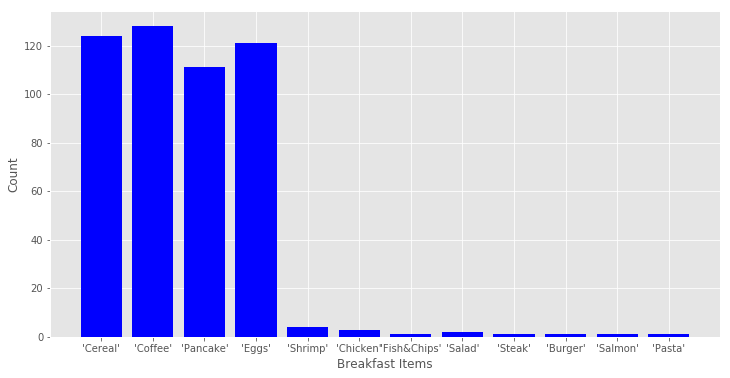

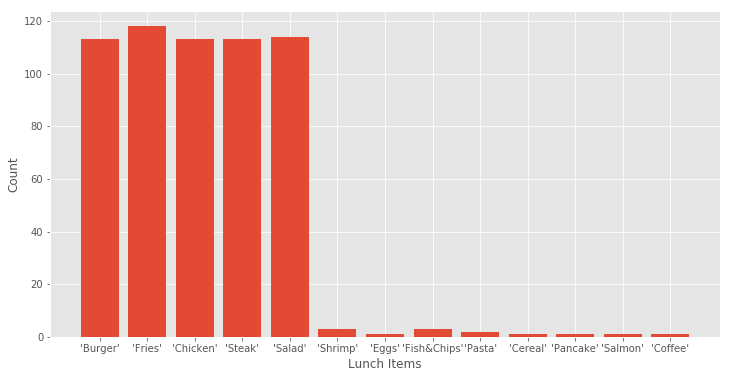

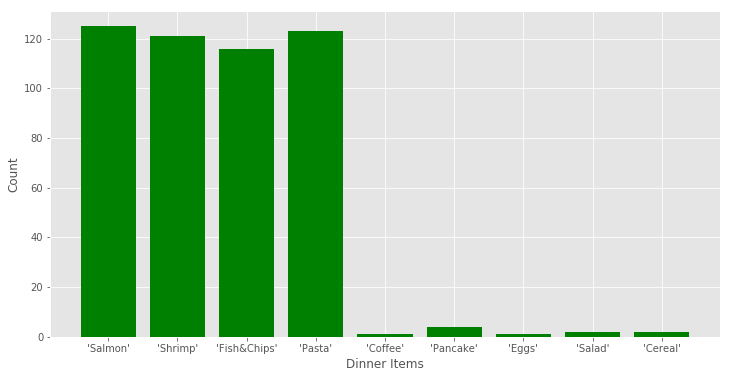

In [88]:
plt.figure(figsize=(12,6))
plt.bar(range(len(Counter(breakfast_items))), list(Counter(breakfast_items).values()), color='blue',align='center')
plt.xticks(range(len(Counter(breakfast_items))), list(Counter(breakfast_items).keys()))
plt.xlabel('Breakfast Items')
plt.ylabel('Count')

plt.figure(figsize=(12,6))
plt.bar(range(len(Counter(lunch_items))), list(Counter(lunch_items).values()), align='center')
plt.xticks(range(len(Counter(lunch_items))), list(Counter(lunch_items).keys()))
plt.xlabel('Lunch Items')
plt.ylabel('Count')

plt.figure(figsize=(12,6))
plt.bar(range(len(Counter(dinner_items))), list(Counter(dinner_items).values()), color='green',align='center')
plt.xticks(range(len(Counter(dinner_items))), list(Counter(dinner_items).keys()))
plt.xlabel('Dinner Items')
plt.ylabel('Count')

Firstly, we see that some items in each order_type have significantly higher count than the rest of items in the same order_type. Moreover, the items which appear with a lower count appears with higher count for the same items in different order_type.

This clearly shows that one order_type contains items of other two order_types.<br>
For example,
breakfast items contains items from lunch and dinner.<br>
lunch items contains item from dinner and breakfast.<br>
dinner items contains item from breakfast and lunch.<br>

As it is stated that one order_type cannot contain the items of other order_type, we need to fix these errors.

#### Making a list of all correct items from bf, lunch, dinner order_type
We will create a list of correct items for each order type and create a regex pattern which can be used later to match those patterns in the order_items column.

In [93]:
#breakfast items
bf_list = ["Cereal", "Pancake", "Eggs", "Coffee"]
bf_pattern = '|'.join(bf_list)

#lunch items
lunch_list = ["Salad", "Steak", "Chicken", "Burger", "Fries"]
lunch_pattern = '|'.join(lunch_list)

#dinner items
dinner_list = ['Salmon', 'Shrimp', 'Fish&Chips', 'Pasta']
dinner_pattern = '|'.join(dinner_list)

## Anomalies in breakfast order_type:
### lunch items in breakfast

Lets find rows having lunch items in the breakfast order. Here, we will use lunch_pattern that we generated above.

In [94]:
#check if order_type is breakfast and order_items contains lunch_pattern as regex
dirty_df[(dirty_df['order_type']=='Breakfast') & (dirty_df['order_items'].str.contains(pat = lunch_pattern, regex=True))]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
82,ORDZ04571,2018-02-28,09:51:32,Breakfast,NS,"[('Eggs', 5), ('Chicken', 5)]",231.25,-37.803102,144.929182,0,10.062,15.158952
206,ORDZ06873,2018-01-01,08:00:00,Breakfast,NS,"[('Coffee', 4), ('Salad', 9), ('Eggs', 10)]",439.00,-37.814084,144.944512,1,9.292,7.113894
224,ORDC10052,2018-01-02,08:00:00,Breakfast,NS,"[('Steak', 10), ('Eggs', 2), ('Cereal', 3)]",349.50,-37.820303,144.946512,1,9.782,7.131812
284,ORDA00420,2018-01-27,08:50:42,Breakfast,BK,"[('Cereal', 7), ('Coffee', 5), ('Burger', 6), ('Pancake', 3)]",389.25,-37.799210,144.959481,0,8.420,15.108077
285,ORDZ10661,2018-02-06,09:10:59,Breakfast,NS,"[('Cereal', 7), ('Chicken', 6), ('Eggs', 7)]",346.00,-37.822261,144.938888,0,10.652,15.357602
383,ORDK05425,2018-03-29,10:52:23,Breakfast,BK,"[('Coffee', 4), ('Salad', 7), ('Pancake', 10)]",426.50,-37.801576,144.996757,0,5.359,10.533008
423,ORDX00963,2018-01-02,08:00:00,Breakfast,BK,"[('Pancake', 5), ('Eggs', 6), ('Coffee', 1), ('Chicken', 9)]",449.75,-37.814861,144.944973,1,9.167,7.940265


### Dinner items in breakfast

Lets find rows having dinner items in the breakfast order. Here, we will use dinner_pattern that we generated above.

In [96]:
#check if order_type is breakfast and order_items contains dinner_pattern as regex
dirty_df[(dirty_df['order_type']=='Breakfast') & (dirty_df['order_items'].str.contains(pat = dinner_pattern, regex=True))]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
49,ORDI10869,2018-01-09,08:10:08,Breakfast,NS,"[('Coffee', 9), ('Shrimp', 7)]",237.25,-37.802592,144.980063,1,7.063,5.943426
62,ORDI02115,2018-04-07,11:02:32,Breakfast,NS,"[('Shrimp', 2), ('Cereal', 8)]",216.50,-37.822702,145.007615,0,11.149,18.464949
177,ORDB09756,2018-02-10,09:10:59,Breakfast,TP,"[('Fish&Chips', 6), ('Coffee', 6)]",190.50,-37.808847,144.966125,0,8.851,13.200995
187,ORDA00980,2018-02-27,09:51:32,Breakfast,BK,"[('Shrimp', 7), ('Coffee', 6), ('Eggs', 7), ('Cereal', 2)]",410.75,-37.822910,144.975189,0,7.544,12.637497
287,ORDY08945,2018-05-01,11:53:14,Breakfast,TP,"[('Coffee', 9), ('Salmon', 2), ('Eggs', 8)]",285.50,-37.809301,144.950196,0,9.493,12.191085
295,ORDI02612,2018-03-08,10:11:49,Breakfast,NS,"[('Pasta', 7), ('Eggs', 10), ('Cereal', 6), ('Pancake', 4)]",495.50,-37.816343,144.965714,0,8.293,13.219059
341,ORDB05518,2018-02-27,09:51:32,Breakfast,TP,"[('Pancake', 4), ('Shrimp', 5), ('Coffee', 3), ('Eggs', 2)]",268.50,-37.809477,144.972299,0,9.092,11.536302


##  Anomalies in Lunch order_type

### Breakfast items in lunch
Lets find rows having breakfast items in the lunch order. Here, we will use bf_pattern that we generated above.

In [98]:
#check if order_type is lunch and order_items contains bf_pattern as regex
dirty_df[(dirty_df['order_type']=='Lunch') & (dirty_df['order_items'].str.contains(pat = bf_pattern, regex=True))]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
40,ORDX00071,2018-08-11,15:16:03,Lunch,BK,"[('Chicken', 1), ('Salad', 5), ('Eggs', 3), ('Burger', 7), ('Fries', 3)]",506.0,-37.818589,144.953297,0,10.416,18.913069
253,ORDZ00149,2018-08-19,15:36:20,Lunch,NS,"[('Burger', 5), ('Cereal', 1)]",187.0,-37.813453,144.935754,0,10.188,17.534652
342,ORDA08753,2018-07-09,14:15:12,Lunch,BK,"[('Burger', 10), ('Pancake', 3), ('Salad', 9)]",560.8,-37.798981,144.936407,0,10.077,16.377594
412,ORDC08462,2018-08-20,15:36:20,Lunch,NS,"[('Coffee', 6), ('Salad', 3), ('Burger', 4)]",445.6,-37.801431,144.979769,0,7.006,12.305033


### Dinner items in lunch
Lets find rows having dinner items in the lunch order. Here, we will use dinner_pattern that we generated above.

In [100]:
#check if order_type is lunch and order_items contains dinner_pattern as regex
dirty_df[(dirty_df['order_type']=='Lunch') & (dirty_df['order_items'].str.contains(pat = dinner_pattern, regex=True))]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
11,ORDZ03322,2018-08-18,15:36:20,Lunch,NS,"[('Shrimp', 9), ('Fries', 4), ('Chicken', 6)]",645.0,-37.812955,144.968006,0,7.657,15.563597
76,ORDJ08366,2018-08-22,15:46:28,Lunch,TP,"[('Salad', 6), ('Fish&Chips', 9), ('Fries', 2), ('Chicken', 6), ('Burger', 2)]",786.2,-37.820184,144.968612,0,7.607,11.307932
93,ORDZ05728,2018-07-13,14:25:21,Lunch,NS,"[('Pasta', 1), ('Salad', 5), ('Fries', 8), ('Chicken', 8), ('Steak', 6)]",739.0,-37.816459,145.004164,0,10.313,16.283618
254,ORDA00572,2018-05-03,12:03:22,Lunch,BK,"[('Fish&Chips', 8), ('Fries', 5), ('Steak', 3)]",451.0,-37.820419,144.926592,0,11.418,17.418849
303,ORDY07439,2018-05-10,12:13:31,Lunch,TP,"[('Chicken', 9), ('Pasta', 2), ('Fries', 10)]",498.0,-37.817166,144.967727,0,7.796,11.520321
305,ORDB09054,2018-05-04,12:03:22,Lunch,TP,"[('Shrimp', 4), ('Salad', 9)]",278.8,-37.801422,144.995142,0,11.392,13.954860
366,ORDA10285,2018-07-26,14:45:38,Lunch,BK,"[('Salmon', 8), ('Chicken', 6), ('Fries', 4), ('Steak', 3)]",623.0,-37.803792,144.960299,0,7.883,14.026520
413,ORDK10188,2018-07-26,14:45:38,Lunch,BK,"[('Burger', 8), ('Shrimp', 2), ('Chicken', 6), ('Salad', 1)]",481.2,-37.802084,144.960526,0,8.052,13.893748
494,ORDA00125,2018-08-18,15:36:20,Lunch,BK,"[('Salad', 2), ('Fish&Chips', 7)]",349.4,-37.812641,144.969039,0,7.189,16.031057


## Anomalies in Dinner order_type

### Breakfast items in Dinner
Lets find rows having breakfast items in the dinner order. Here, we will use bf_pattern that we generated above.

In [102]:
#check if order_type is dinner and order_items contains bf_pattern as regex
dirty_df[(dirty_df['order_type']=='Dinner') & (dirty_df['order_items'].str.contains(pat = bf_pattern, regex=True))]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
17,ORDJ01619,2018-10-30,17:58:18,Dinner,TP,"[('Pasta', 9), ('Coffee', 3)]",409.5,-37.811890,144.961394,0,8.460,12.896070
100,ORDX00279,2018-11-23,18:49:00,Dinner,BK,"[('Shrimp', 9), ('Pancake', 7), ('Fish&Chips', 9), ('Pasta', 9)]",1335.5,-37.812405,144.931634,0,11.156,18.583754
152,ORDK06151,2018-09-20,16:37:10,Dinner,BK,"[('Fish&Chips', 3), ('Pancake', 4)]",321.0,-37.824814,145.014828,0,4.966,11.745924
319,ORDY06423,2018-10-02,17:07:36,Dinner,TP,"[('Fish&Chips', 6), ('Eggs', 9), ('Salmon', 8)]",785.5,-37.802943,144.963357,0,9.539,13.221542
370,ORDX11015,2018-11-19,18:38:52,Dinner,BK,"[('Pancake', 5), ('Shrimp', 3)]",367.0,-37.823797,144.990237,0,6.222,13.014968
374,ORDY03347,2018-10-10,17:17:44,Dinner,TP,"[('Salmon', 5), ('Cereal', 8)]",637.0,-37.812093,144.951315,0,9.238,13.382188
393,ORDI04200,2018-09-27,16:57:27,Dinner,NS,"[('Cereal', 1), ('Pasta', 10)]",316.0,-37.807818,144.943761,0,9.172,15.350900
496,ORDJ06556,2018-10-21,17:38:01,Dinner,TP,"[('Shrimp', 10), ('Pancake', 2), ('Salmon', 10), ('Fish&Chips', 10)]",1355.0,-37.799920,144.962686,0,9.770,15.402748


### Lunch items in dinner
Lets find rows having lunch items in the dinner order. Here, we will use lunch_pattern that we generated above.

In [104]:
#check if order_type is dinner and order_items contains lunch_pattern as regex
dirty_df[(dirty_df['order_type']=='Dinner') & (dirty_df['order_items'].str.contains(pat = lunch_pattern, regex=True))]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
372,ORDA01879,2018-10-02,17:07:36,Dinner,BK,"[('Salad', 7), ('Shrimp', 3), ('Salmon', 10)]",764.5,-37.820633,144.966853,0,7.888,14.931119
379,ORDI03215,2018-10-07,17:17:44,Dinner,NS,"[('Pasta', 6), ('Salad', 9)]",651.0,-37.802607,144.965868,0,6.700,14.316585


As we need to replace the wrong items in an order_type, we will need to change the corresponding order_price as well.

As we know that one row can only contain one error, and if the row has error in order_items, its corresponding order_price needs to be correct. So we will change the order_items such that it matches the order_price.

For this to be done, we need to find the price of each item. As we know that outlier_df has correct records, we can use this data to find the price of each item.

### Finding items price using outliers data

In [106]:
outlier_df = pd.read_csv('outlier_data.csv')
outlier_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDB04342,2018-11-07,18:18:35,Dinner,TP,"[('Salmon', 1), ('Shrimp', 1)]",95.0,-37.810266,144.961484,0,8.485,13.022277
1,ORDA07851,2018-11-12,18:28:43,Dinner,BK,"[('Fish&Chips', 1), ('Pasta', 8)]",255.0,-37.817640,144.959233,0,8.216,15.273881
2,ORDK06202,2018-04-23,11:43:05,Breakfast,BK,"[('Cereal', 6), ('Pancake', 10), ('Eggs', 9), ('Coffee', 9)]",634.0,-37.818799,144.953368,0,8.795,13.730281
3,ORDB01269,2018-06-05,13:04:13,Lunch,TP,"[('Fries', 8), ('Chicken', 6), ('Burger', 2)]",350.0,-37.808375,144.928804,0,11.863,15.189335
4,ORDJ09923,2018-09-13,16:27:02,Dinner,TP,"[('Fish&Chips', 6), ('Shrimp', 5)]",480.0,-37.800900,144.953532,0,9.890,13.425604


We will find price each item in each of the orders. For this, we will use just rows equal to number of unique items in each order_type, as if there are n unique items in an order, n equations are enough to solve n variables.

So for breakfast, dinner we will use 4 rows, and for lunch we will use 5 rows as there are 5 unique items. 

For each order_items record, we will use following regex to get item and its quantity.

**regex explanation:**

```python
re.findall('\'([a-zA-Z&]+)\', ([\d]+)', each_order)
```

We will capture all items in an order_items using (a-zA-Z&) group which will match all characters with a-Z and &. Also ([d]+) will capture all digits and get the quantity of each item.

Once we get these data, we will store this info in (order_type) _orders list. We will make sure the quantities added to the list are appended in correct order.

For eg,
items_count for breakfast should be list of quantities of 4 items in following order.<br>
`[Cereal_qty, Pancake_qty, Eggs_qty, Coffee_qty]`

items_count for lunch should be list of quantities of 5 items in following order.<br>
`[Salad_qty,Steak_qty,Chicken_qty,Burger_qty,Fries_qty]`

items_count for dinner should be list of quantities of 5 items in following order.<br>
`[Salmon_qty, Shrimp_qty, Fish&Chips_qty, Pasta_qty]`

We will store order_price for such rows and we will solve system of linear quations using `linalg` package.

In [107]:
#list storing variables of breakfast orders
bf_orders = []
for each_order in outlier_df[outlier_df['order_type']=='Breakfast'][:4]['order_items']:
    order = re.findall('\'([a-zA-Z&]+)\', ([\d]+)', each_order)
    items_count = [0]*4
    #storing quantity of breakfast items in order described above
    for i, j in order:
        items_count[bf_list.index(i)]=int(j)
    #Appending quantities in each order to order_list
    bf_orders.append(items_count)

#Storing order_price of these orders
bf_total = list(outlier_df[outlier_df['order_type']=='Breakfast'][:4]['order_price'])

In [108]:
#converting list to np array
bf_eqn = np.array(bf_orders)
bf_total = np.array(bf_total)
#Solving linear equations to get output as list of price
bf_price = np.linalg.solve(bf_eqn, bf_total)
bf_price

array([21.  , 24.25, 22.  ,  7.5 ])

In [109]:
#list storing variables of lunch orders
lunch_orders = []
for each_order in outlier_df[outlier_df['order_type']=='Lunch'][:5]['order_items']:
    order = re.findall('\'([a-zA-Z&]+)\', ([\d]+)', each_order)
    items_count = [0]*5
     #storing quantity of lunch items in order described above
    for i, j in order:
        items_count[lunch_list.index(i)]=int(j)
    #Appending quantities in each order to order_list
    lunch_orders.append(items_count)
    
#Storing order_price of these orders
lunch_total = list(outlier_df[outlier_df['order_type']=='Lunch'][:5]['order_price'])

In [110]:
#converting list to np array
lunch_eqn = np.array(lunch_orders)
lunch_total = np.array(lunch_total)
#Solving linear equations to get output as list of price
lunch_price = np.linalg.solve(lunch_eqn, lunch_total)
lunch_price

array([17.2, 45. , 32. , 31. , 12. ])

In [111]:
#list storing variables of dinner orders
dinner_orders = []
for each_order in outlier_df[outlier_df['order_type']=='Dinner'][:4]['order_items']:
    order = re.findall('\'([a-zA-Z&]+)\', ([\d]+)', each_order)
    items_count = [0]*4
    #storing quantity of dinner items in order described above
    for i, j in order:
        items_count[dinner_list.index(i)]=int(j)
    #Appending quantities in each order to order_list
    dinner_orders.append(items_count)
    
#Storing order_price of these orders
dinner_total = list(outlier_df[outlier_df['order_type']=='Dinner'][:4]['order_price'])

In [112]:
#converting list to np array
dinner_eqn = np.array(dinner_orders)
dinner_total = np.array(dinner_total)
#Solving linear equations to get output as list of price
dinner_price = np.linalg.solve(dinner_eqn, dinner_total)
dinner_price

array([41. , 54. , 35. , 27.5])

We will round the value to 2 digits.

In [113]:
bf_price = bf_price.round(2)
lunch_price = lunch_price.round(2)
dinner_price = dinner_price.round(2)

## Fixing these anomalies:

For each order_type, we will try to find items which are errorneously present in that order_items, (eg. lunch item being present in breakfast order) and we will subtract order_price*qty from total order_price for all items present in the order_items except the errorneaous item and store its quantity in qty variable.

The leftover amount is divided by the quantity of errorneous item, and we will match this value with price of each item for that particular order_type and we will replace that errorneaous item with the matched item for that particular order_items.

We will do these for all order_types

### Find and fix erronerous order types present in each order_type

In [114]:
def fix_order_type(order_type, order_pattern, otype_price, otype_list):
    ''''
    It fixes errorneous order_type values presents in each type of order
    
    Args:
        order_type: type of order which needs to be fixed
        order_pattern: pattern for incorrect order_type present
        otype_price: List containing price for each item in order_type
        otype_list: List containing the items for order_type 
    '''
    # order rows containing lunch item
    dirty_rows = dirty_df[(dirty_df['order_type']==order_type) & 
                          (dirty_df['order_items'].str.contains(pat = lunch_pattern, regex=True))]

    # total of order
    order_total = list(dirty_rows['order_price'])

    # enumerate over index of dirty rows
    for idx, order_row in enumerate(list(dirty_rows['order_items'].index)):
        qty = 0
        items = re.findall('\'([a-zA-Z&]+)\', ([\d]+)', dirty_df['order_items'][order_row])
        for i,j in items:
            # check if item is not present in order_type list
            if i not in bf_list:
                qty = int(j)
                continue
            # subtract orderItem_price*quantity from total order_price
            order_total[idx] -= otype_price[otype_list.index(i)]*int(j)
        # replace the errorneous item with correct one
        dirty_df.at[order_row, 'order_items'] = re.sub(order_pattern,
                                                       otype_list[list(otype_price).index(round(order_total[idx]/qty,2))], 
                                                       dirty_df['order_items'][order_row])

In [ ]:
fix_order_type('Breakfast', lunch_pattern, bf_price, bf_list) # Fix lunch items present in Breakfast
fix_order_type('Breakfast', dinner_pattern, bf_price, bf_list) # Fix dinner items present in Breakfast
fix_order_type('Dinner', lunch_pattern, dinner_price, dinner_list) # Fix lunch items present in Dinner
fix_order_type('Dinner', bf_pattern, dinner_price, dinner_list)  # Fix breakfast items present in Dinner
fix_order_type('Lunch', dinner_pattern, lunch_price, lunch_list) # Fix dinner items present in Lunch
fix_order_type('Lunch', bf_pattern, lunch_price, lunch_list) # Fix breakfast items present in Lunch

Lets check if there are errors in order_price.

### Fixing rows corresponding to each order_type with incorrect order_price

We will check if the sum of price of each item* quantity for each item in order_items is equal to order_price. If it isn't the case we will replace it with the sum we calculated.

We will do this for orders of each order_type.

In [121]:
def fix_order_price(order_type, otype_price, otype_list):
    '''
    It fixes order price for `order_type` rows
    
    Args:
        order_type: type of the order for which order_price needs to be
                    fixed
        otype_price: List containing price for each item in order_type
        otype_list: List containing the items for order_type 
    '''
    order_total = list(dirty_df[dirty_df['order_type']==order_type]['order_price'])

    for idx, order_row in enumerate(list(dirty_df[dirty_df['order_type']==order_type].index)):
        sum = 0
        # find items with its quantity
        items = re.findall('\'([a-zA-Z&]+)\', ([\d]+)', dirty_df['order_items'][order_row])
        # find total order_price as sum
        for i,j in items:
            sum += otype_price[otype_list.index(i)]*int(j)
        # Check if order_price is correct
        if order_total[idx] != sum:
            dirty_df.at[order_row, 'order_price'] = sum

In [122]:
fix_order_price('Breakfast', bf_price, bf_list) # Fixing breakfast rows with incorrect order_price
fix_order_price('Lunch', lunch_price, lunch_list) # Fixing Lunch rows with incorrect order_price
fix_order_price('Dinner', dinner_price, dinner_list) # Fixing Dinner rows with incorrect order_price

## 5.6 Fix distance_to_cumstomer_KM

For checking if the distance to customer is correct, we need to build a graph and find the distance between customer lat long and restaurant branch code.

We will build the graph using nodes.csv and edges.csv through `networkxx` library.

We will then calculate dijkstras distance from customer node to restaurant node and check if it is matching the distance provided in the dataset.

As we already built the graph, while imputing missing distance_to_customer_KM in missing_df. So we will use that graph to calculate dijkstra dist.

We will merge nodes_df and dirty_df to get the nodes corresponding to latitude and longitude

In [123]:
dirty_nodes_df = pd.merge(dirty_df, nodes_df, how='inner',left_on = ['customer_lat', 'customer_lon'], right_on= ['lat', 'lon'])
dirty_nodes_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,node,lat,lon
0,ORDX05220,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 8), ('Shrimp', 3), ('Fish&Chips', 2), ('Pasta', 7)]",752.5,-37.807758,144.943627,0,8.090,16.146092,387152934,-37.807758,144.943627
1,ORDY02858,2018-12-26,19:49:51,Dinner,TP,"[('Pasta', 9), ('Salmon', 1), ('Fish&Chips', 2)]",358.5,-37.801732,144.957615,0,9.510,13.251254,778827738,-37.801732,144.957615
2,ORDJ07185,2018-11-09,18:18:35,Dinner,TP,"[('Fish&Chips', 1), ('Salmon', 4), ('Shrimp', 9)]",685.0,-37.814718,144.950696,0,9.005,13.174748,291483918,-37.814718,144.950696
3,ORDB06291,2018-01-03,08:00:00,Breakfast,TP,"[('Cereal', 3), ('Coffee', 7), ('Pancake', 8)]",309.5,-37.812759,144.941368,1,10.136,6.085497,1224869075,-37.812759,144.941368
4,ORDI09940,2018-07-18,14:35:29,Lunch,NS,"[('Burger', 3), ('Fries', 7)]",177.0,-37.800347,144.978114,0,6.858,12.301354,4297530195,-37.800347,144.978114


In [124]:
#Drop unnecessary repeating nodes
dirty_nodes_df.drop(['lat', 'lon'], axis=1, inplace=True)

Lets check the length of the data frame to see if duplicate rows are not present after merging

In [125]:
len(dirty_nodes_df)

502

The total rows in the original dataframe was 500. But now we got 502. That means, some rows are duplicated.

Lets find these rows using duplicated method. 

In [126]:
dirty_nodes_df[dirty_nodes_df['order_id'].duplicated(keep=False)] 

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,node
43,ORDA11027,2018-09-25,16:47:19,Dinner,BK,"[('Shrimp', 4), ('Salmon', 4), ('Fish&Chips', 6), ('Pasta', 7)]",782.5,-37.819726,144.969655,0,8.09,15.165117,243963290
44,ORDA11027,2018-09-25,16:47:19,Dinner,BK,"[('Shrimp', 4), ('Salmon', 4), ('Fish&Chips', 6), ('Pasta', 7)]",782.5,-37.819726,144.969655,0,8.09,15.165117,6182893637
45,ORDA11027,2018-09-25,16:47:19,Dinner,BK,"[('Shrimp', 4), ('Salmon', 4), ('Fish&Chips', 6), ('Pasta', 7)]",782.5,-37.819726,144.969655,0,8.09,15.165117,6182893638


We see that order_id ORDA11027 has multiple entries after merging. If we see the node column for this order_id, node column data is different. This means that multiple nodes(here 3) corresponds to same latitude and longitude. 

We need to find distance to each of the node 

In [127]:
dirty_nodes_df[dirty_nodes_df['order_id'].duplicated(keep=False)]['node']

43     243963290
44    6182893637
45    6182893638
Name: node, dtype: int64

Which means three nodes corresponds to same latitude longitude.

We need to find the exact match of the distance.

We will create a new column dijkstra_dist where we will store dijkstra distance calculated from the graph we made.

In [128]:
dirty_nodes_df['dijkstra_dist'] = pd.Series()

In [129]:
dirty_nodes_df = pd.merge(dirty_nodes_df, branches_df[['branch_code', 'from_node']], on="branch_code")
dirty_nodes_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,node,dijkstra_dist,from_node
0,ORDX05220,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 8), ('Shrimp', 3), ('Fish&Chips', 2), ('Pasta', 7)]",752.5,-37.807758,144.943627,0,8.090,16.146092,387152934,NaN,1889485053
1,ORDK03735,2018-08-11,15:16:03,Lunch,BK,"[('Chicken', 9), ('Steak', 6)]",558.0,-37.820104,145.015819,0,4.584,13.203457,1426668397,NaN,1889485053
2,ORDX01196,2018-12-16,19:29:34,Dinner,BK,"[('Shrimp', 1), ('Salmon', 6)]",300.0,-37.824406,144.944700,0,11.156,19.405397,571731483,NaN,1889485053
3,ORDA09024,2018-01-09,08:10:08,Breakfast,BK,"[('Pancake', 4), ('Cereal', 4)]",181.0,-37.805817,144.981288,1,6.129,5.647115,2090732596,NaN,1889485053
4,ORDX00943,2018-12-05,19:09:17,Dinner,BK,"[('Pasta', 7), ('Shrimp', 1), ('Salmon', 10), ('Fish&Chips', 5)]",831.5,-37.814424,145.014941,0,4.738,11.304695,207085717,NaN,1889485053


We will calculate the dijstra_dist using the function we developed while handling missing data.

In [130]:
dirty_nodes_df['dijkstra_dist'] = dirty_nodes_df[['from_node','node']].apply(lambda x: f(x), axis=1)

Lets look closely at these duplicated rows

In [131]:
dirty_nodes_df[dirty_nodes_df['order_id'].duplicated(keep=False)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,node,dijkstra_dist,from_node
17,ORDA11027,2018-09-25,16:47:19,Dinner,BK,"[('Shrimp', 4), ('Salmon', 4), ('Fish&Chips', 6), ('Pasta', 7)]",782.5,-37.819726,144.969655,0,8.09,15.165117,243963290,7.775,1889485053
18,ORDA11027,2018-09-25,16:47:19,Dinner,BK,"[('Shrimp', 4), ('Salmon', 4), ('Fish&Chips', 6), ('Pasta', 7)]",782.5,-37.819726,144.969655,0,8.09,15.165117,6182893637,7.811,1889485053
19,ORDA11027,2018-09-25,16:47:19,Dinner,BK,"[('Shrimp', 4), ('Salmon', 4), ('Fish&Chips', 6), ('Pasta', 7)]",782.5,-37.819726,144.969655,0,8.09,15.165117,6182893638,8.090,1889485053


We will consider the row where distance_to_customer is matching with dijsktra dist that we calculated row only among these three rows.

In [132]:
dirty_nodes_df = dirty_nodes_df.drop(dirty_nodes_df[(dirty_nodes_df['order_id'].duplicated(keep=False)) & (dirty_nodes_df['distance_to_customer_KM'] != dirty_nodes_df['dijkstra_dist'])].index)

So the rows will be 500 again.

In [133]:
dirty_nodes_df.shape

(500, 15)

Now lets see rows where these distance_to_customer do not match with dijsktra dist.

In [134]:
dirty_nodes_df[dirty_nodes_df['distance_to_customer_KM']!=dirty_nodes_df['dijkstra_dist']]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,node,dijkstra_dist,from_node
0,ORDX05220,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 8), ('Shrimp', 3), ('Fish&Chips', 2), ('Pasta', 7)]",752.50,-37.807758,144.943627,0,8.090,16.146092,387152934,9.356,1889485053
2,ORDX01196,2018-12-16,19:29:34,Dinner,BK,"[('Shrimp', 1), ('Salmon', 6)]",300.00,-37.824406,144.944700,0,11.156,19.405397,571731483,9.790,1889485053
9,ORDX03467,2018-01-30,08:50:42,Breakfast,BK,"[('Coffee', 3), ('Pancake', 10), ('Cereal', 7)]",412.00,-37.800620,144.978085,0,7.937,11.963909,30287471,6.911,1889485053
11,ORDK04455,2018-11-23,18:49:00,Dinner,BK,"[('Pasta', 3), ('Fish&Chips', 9), ('Salmon', 6)]",643.50,-37.798740,144.989296,0,6.207,13.202239,384027031,6.207,1889485053
14,ORDK08132,2018-02-27,09:51:32,Breakfast,BK,"[('Coffee', 3), ('Pancake', 3), ('Eggs', 1)]",117.25,-37.809762,144.975910,0,6.547,11.980784,6245731106,6.547,1889485053
15,ORDA04396,2018-02-27,09:51:32,Breakfast,BK,"[('Cereal', 5), ('Coffee', 5)]",142.50,-37.809762,144.975910,0,6.547,11.181143,6245731106,6.547,1889485053
16,ORDX00071,2018-08-11,15:16:03,Lunch,BK,"[('Chicken', 1), ('Salad', 5), ('Steak', 3), ('Burger', 7), ('Fries', 3)]",506.00,-37.818589,144.953297,0,10.416,18.913069,3967630097,10.416,1889485053
21,ORDK04380,2018-03-16,10:21:58,Breakfast,BK,"[('Pancake', 6), ('Eggs', 6)]",277.50,-37.808149,144.942601,0,9.137,14.641480,655124685,9.644,1889485053
26,ORDX09331,2018-09-02,16:06:45,Dinner,BK,"[('Fish&Chips', 5), ('Pasta', 1)]",202.50,-37.811760,144.971273,0,6.951,16.134975,6167417980,6.951,1889485053
28,ORDX10004,2018-11-14,18:28:43,Dinner,BK,"[('Salmon', 8), ('Pasta', 1), ('Fish&Chips', 5)]",530.50,-37.800370,144.963537,0,8.027,15.190382,312719433,8.027,1889485053


We see that some values look equal in the above rows still we are seeing such rows.

So closely looking at those values we see that some values have plenty of trailing decimal digits (eg. 25.00000000001). So we need to round these values to 3 decimal places and then compare it with dijkstra dist.

In [135]:
dirty_nodes_df['distance_to_customer_KM'] = round(dirty_nodes_df['distance_to_customer_KM'],3)

Now lets again find rows where these values do not match.

In [136]:
dirty_nodes_df[dirty_nodes_df['distance_to_customer_KM']!=dirty_nodes_df['dijkstra_dist']]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,node,dijkstra_dist,from_node
0,ORDX05220,2018-09-27,16:57:27,Dinner,BK,"[('Salmon', 8), ('Shrimp', 3), ('Fish&Chips', 2), ('Pasta', 7)]",752.50,-37.807758,144.943627,0,8.090,16.146092,387152934,9.356,1889485053
2,ORDX01196,2018-12-16,19:29:34,Dinner,BK,"[('Shrimp', 1), ('Salmon', 6)]",300.00,-37.824406,144.944700,0,11.156,19.405397,571731483,9.790,1889485053
9,ORDX03467,2018-01-30,08:50:42,Breakfast,BK,"[('Coffee', 3), ('Pancake', 10), ('Cereal', 7)]",412.00,-37.800620,144.978085,0,7.937,11.963909,30287471,6.911,1889485053
21,ORDK04380,2018-03-16,10:21:58,Breakfast,BK,"[('Pancake', 6), ('Eggs', 6)]",277.50,-37.808149,144.942601,0,9.137,14.641480,655124685,9.644,1889485053
44,ORDX10329,2018-01-14,08:20:16,Breakfast,BK,"[('Cereal', 10), ('Eggs', 3), ('Pancake', 2), ('Coffee', 5)]",362.00,-37.812326,144.973574,1,10.287,7.467864,4746121968,6.791,1889485053
68,ORDA03602,2018-09-26,16:57:27,Dinner,BK,"[('Salmon', 9), ('Shrimp', 3)]",531.00,-37.810846,144.951643,0,6.459,15.691032,3151854212,8.589,1889485053
83,ORDA08107,2018-08-17,15:36:20,Lunch,BK,"[('Steak', 9), ('Fries', 9)]",513.00,-37.800197,144.987587,0,8.077,12.340884,1985429676,6.190,1889485053
99,ORDK05493,2018-03-15,10:21:58,Breakfast,BK,"[('Eggs', 7), ('Pancake', 7)]",323.75,-37.807883,144.971375,0,8.969,11.739512,767583992,6.692,1889485053
113,ORDX07426,2018-09-04,16:06:45,Dinner,BK,"[('Pasta', 5), ('Fish&Chips', 9)]",452.50,-37.812173,144.938044,0,8.049,16.481753,310728350,9.914,1889485053
136,ORDX10490,2018-08-18,15:36:20,Lunch,BK,"[('Burger', 7), ('Steak', 8), ('Salad', 6), ('Chicken', 9), ('Fries', 2)]",992.20,-37.808432,144.971637,0,9.452,14.803827,26034664,6.726,1889485053


In [137]:
dirty_nodes_df[dirty_nodes_df['distance_to_customer_KM']!=dirty_nodes_df['dijkstra_dist']].shape

(37, 15)

There are 37 such rows. We will fix these errors by replacing values of distane_to_customer_KM to dijkstra dist that we calculated.

In [138]:
dirty_nodes_df['distance_to_customer_KM'] = dirty_nodes_df['dijkstra_dist']

## 5.7 FIx customer_has_loyalty? column anomalies

We will now check for errors in the customerHasloyalty? attribute. The approach followed is to use the linear regression model created while imputing missing values, predict delivery_fee and identify those records that have a significant variance between predicted delivery_fee and the delivery_fee given in the data. 

We first transform dirty_df to create the required predictor variables and then predict delivery_fee values. The lr_transform function was created while imputing missing values.

In [139]:
# Transforming the dataframe
test_df = lr_transform(dirty_nodes_df)

# Predicting delivery_fee values
test_df['pred_delivery_fee'] = test_df.apply(
    lambda x: prediction(x['branch_code'],x['is_weekend'],x['time_of_day'],x['distance_to_customer_KM'],
                         x['customerHasloyalty?'])[0], axis=1
)

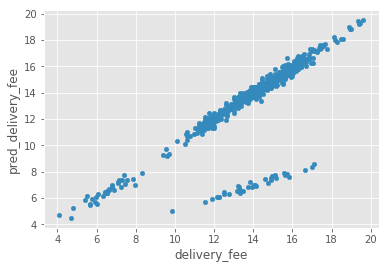

In [140]:
ax1 = test_df.plot.scatter(x='delivery_fee',y='pred_delivery_fee')

We see from the plot of predicted_delivery_fee vs delivery_fee that for some records, there is a huge difference between the values. The variance between the values also seem to increase fo increasing values of delivery fee. Hence to normalise the comparison of differences across different records, we need to use a measure of proportion. Hence we calculate the residual_proportion which is (pred_delivery_fee - delivery_fee)/delivery_fee.

In [141]:
# Creating a function to calculate the residual_proportion
def calc_proportion (x, y):
        return (x - y)/y

# Calculating the residual_proportion
test_df['residual_proportion'] = test_df.apply(lambda x: calc_proportion(x['pred_delivery_fee'],x['delivery_fee']), axis=1)

To identify records where the deviation in predicted and actual values is significant, we calculate the mean and standard deviation of residual_proportion across all records and set a label is_error to 1 where the residual_proportion for a record is more than three standard deviations away from the mean.

In [142]:
std = test_df["residual_proportion"].std()
mean = test_df["residual_proportion"].mean()

test_df['is_error']=test_df['residual_proportion'].apply(lambda x: 1 if abs(x - mean) >= 3*std else 0)

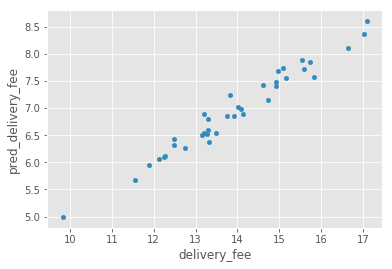

In [143]:
ax1 = test_df[test_df['is_error']==1].plot.scatter(x='delivery_fee',y='pred_delivery_fee')

For the records where is_error = 1, we see that the delivery fee is double the value of the predicted delivery fee. This is because the value of customerHasloyalty? was incorrectly set as one leading to us applying a 50% discount on the predicted delivery fee. Hence, to correct the error, we set the value of customerHasloyalty? to zero for these records.

In [144]:
# Correcting the value of customerHasloyalty? to zero where is_error is one
test_df['customerHasloyalty?'] = test_df.apply(lambda x: x['customerHasloyalty?']-x['is_error'], axis=1)

## Remove unnecessary columns

In [145]:
test_df.columns

Index(['order_id', 'date', 'time', 'order_type', 'branch_code', 'order_items',
       'order_price', 'customer_lat', 'customer_lon', 'customerHasloyalty?',
       'distance_to_customer_KM', 'delivery_fee', 'node', 'dijkstra_dist',
       'from_node', 'is_weekend', 'time_of_day', 'order_hour',
       'norm_deliv_fee', 'pred_delivery_fee', 'residual_proportion',
       'is_error'],
      dtype='object')

In [146]:
test_df.drop(['dijkstra_dist', 'node', 'from_node', 'is_weekend', 'time_of_day', 'order_hour',\
                    'norm_deliv_fee', 'pred_delivery_fee', 'residual_proportion', 'is_error'], axis=1, inplace=True)

We will reorder this dataframe according to the order provided by merging.

In [147]:
dirty_nodes_df = pd.merge(dirty_df['order_id'], test_df, on='order_id')

In [148]:
dirty_nodes_df.shape

(500, 12)

### Saving the solution file

In [149]:
dirty_nodes_df.to_csv('dirty_data_solution.csv', index=False)

# 6. References

[1.] *Python regular expression readings.* Retrieved from https://docs.python.org/3/library/re.html

[2.] *Pythonic way to get dictionaries of count using Counter.* Retrieved from https://stackoverflow.com/questions/11011756/is-there-any-pythonic-way-to-combine-two-dicts-adding-values-for-keys-that-appe

[3.] Jeremy Ruten(2014). *Finding all non-ascii characters*. Retrieved from https://stackoverflow.com/questions/150033/regular-expression-to-match-non-ascii-characters

[4.]  The `pandas` Project. (2016a). *pandas 0.19.2 documentation: pandas.DataFrame.to_csv*. Retrieved from http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html#pandas.DataFrame.to_csv

[5.] `linalg` *Solve system of linear Equations* Retrieved from: https://docs.scipy.org/doc/numpy/reference/routines.linalg.html

[6.] The `networkX 2.3 library`*Shortest Path Distance* formula Retreived from:  https://networkx.github.io/documentation/stable/reference/algorithms/shortest_paths.html

[7.] `sklearn.linear_model.LinearRegression` *Using Linear regression* Retrieved from: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html